# Importing required libraries

In [ ]:
# importing all required libraries

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # for better debugging of CUDA errors

from google.colab import drive 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for xml
import xml.etree.ElementTree as ET

#PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

plt.ion()   # interactive mode
np.random.seed(0)
torch.manual_seed(0)

# Loading Data

The dataset that we are using is "Fask mask Detection". We can directly download it from Kaggle and use it in the same directory as we are working on. Or we can directly download it from kaggle.

Dataset Link: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

## First Way (Just for code Authors)
1. we have to upload the dataset file in some directory in our Google Drive so we can access it later.

2. We may connect to our Google Drive Using following code:

In [ ]:
#moungting to Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#introducing annotations and images
annotation_path = '/content/gdrive/MyDrive/INM705 Project/annotations'
images_path = '/content/gdrive/MyDrive/INM705 Project/images'

## Second way (For Others)

In this way, anyone who has access to this notebook can download the dataset directly from kaggle and run it on Colab and other devices

In [ ]:
import os
!echo <{"username":"mohamadesmaeeli","key":"47b451de763b356065cd33803773d39a"}> ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

os.environ['KAGGLE_USERNAME'] = 'mohamadesmaeeli'
os.environ['KAGGLE_KEY'] = '47b451de763b356065cd33803773d39a'

!kaggle datasets download -d andrewmvd/face-mask-detection

!unzip /content/face-mask-detection.zip

In [ ]:
#introducing annotations and images
annotation_path = '/content/annotations'
images_path = '/content/images/'

# Data Pre-processing

In [ ]:
def encoded_labels(labels_list):
    encoded=[]
    for label in labels_list:
        if label == "with_mask":
            code = 1
        elif label == "mask_weared_incorrect":
            code = 2
        elif label == "without_mask":
            code = 3
        else:
            code = 0 #background
        encoded.append(code)
    return encoded  

In [ ]:
def decode_labels(labels_list):
    labels=[]
    for code in labels_list:
        if code == 1:
            label = "with_mask"
        elif code == 2:
            label = "mask_weared_incorrect"
        elif code == 3:
            label = "without_mask"
        else:
            label = 'background'
        labels.append(label)
    return labels

In [ ]:
class Data(Dataset):

    # Constructor
    def __init__(self, annotation_path, images_path, transform=None, mode=None):

        # Image directories
        self.annotation_path = annotation_path
        self.images_path = images_path
        # The transform is goint to be used on image
        self.transform = transform
        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'Number_of_Objects'])
        
        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(images_path)):
            # Find image annotation file
            ann_file_path = os.path.join(annotation_path, file[1][:-4]) + '.xml'
            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML(ann_file_path)
            # getting the list of labels in an image
            list_labels = encoded_labels(objects[0]['labels'])
            # Create list of bounding boxes in an image
            list_bb = []
            list_area = []
            n_obj = len(objects[0]['objects'])
            for i in objects[0]['objects']:
                new_list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(new_list)
                list_area.append((i['xmax'] - i['xmin']) * (i['ymax'] - i['ymin']))

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels, list_area, n_obj]],
                              columns=['Filename', 'BoundingBoxes', 'Labels', 'Area', 'Number_of_Objects'])
            self.data = self.data.append(df)

        # Number of images in dataset
        self.len = self.data.shape[0]

        if mode == 'train':
            self.data = self.data[:510]
        elif mode == 'validation':
            self.data = self.data[510:680]
        elif mode == 'test':
            self.data = self.data[680:]
        elif mode == 'All':
            self.data = self.data



    # Get the length
    def __len__(self):
        return self.len


   # Getter
    def __getitem__(self, idx):
        # Image file path
        img_name = os.path.join(self.images_path,self.data.iloc[idx, 0])
        # Open image file and tranform to tensor
        image = Image.open(img_name).convert('RGB')
        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])
        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])
        # Get bounding box areas
        area = torch.tensor(self.data.iloc[idx, 3])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            # Convert PIL image to numpy array
            image  = np.array(image )
            # Apply transformations
            transformed = self.transform(image=img, bboxes=bbox)
            # Convert numpy array to PIL Image
            image  = Image.fromarray(transformed['image'])
            # Get transformed bb
            bbox = torch.tensor(transformed['bboxes'])

        # suppose all instances are not crowd
        num_objs = self.data.iloc[idx, 4]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Transform img to tensor
        image = torchvision.transforms.ToTensor()(image)
        # Build Targer dict
        target= {"boxes": bbox, "labels": labels, "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}

        return image, target  
    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML(self, annotation_path):
        bboxes = [{
            'file': annotation_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
       
       #becuase we have multiobjects in the image
        for obj in objects:
            # label
            label = obj.find('name').text  #without_mask/wtih_mask/mask_weared_incorrect	
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes

In [ ]:
# in this part we would split the data. we have mode == 'ALL' in
# case we needed all of images all in one

dataset_all   = Data(annotation_path,images_path, mode = 'All')
dataset_train = Data(annotation_path,images_path, mode = 'train')
dataset_val   = Data(annotation_path,images_path, mode = 'validation')
dataset_test  = Data(annotation_path,images_path, mode = 'test')

# Data Visualization

In this section we would count all faces in the dataset for each class
we would do this step for all dataset splits

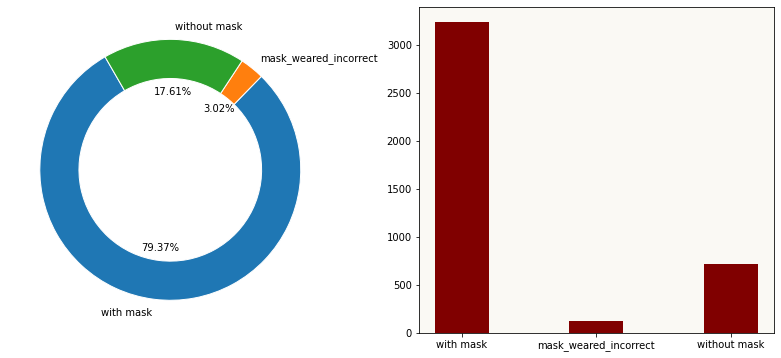

In [ ]:

with_mask_count     = 0
without_mask_count  = 0
non_proper_count    = 0

for image in dataset_all:
  for annots_number in range(len(image[1]['labels'])):
    label = int(image[1]['labels'][annots_number])
    if label   == 1:
      with_mask_count += 1
    elif label == 2:
      non_proper_count += 1
    elif label == 3:
      without_mask_count += 1



fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie([with_mask_count,non_proper_count,without_mask_count],wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=['with mask','mask_weared_incorrect','without mask'], radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(['with mask','mask_weared_incorrect','without mask'], [with_mask_count,non_proper_count,without_mask_count],
              color ='maroon',width = 0.4)

plt.show()

In [ ]:
# Number of each class in the al dataset

with_mask_count,without_mask_count,non_proper_count

(3232, 717, 123)

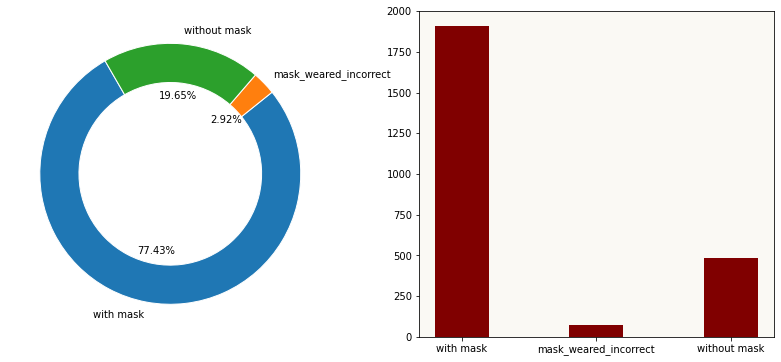

In [ ]:
with_mask_count     = 0
without_mask_count  = 0
non_proper_count    = 0

for image in dataset_train:
  for annots_number in range(len(image[1]['labels'])):
    label = int(image[1]['labels'][annots_number])
    if label   == 1:
      with_mask_count += 1
    elif label == 2:
      non_proper_count += 1
    elif label == 3:
      without_mask_count += 1



fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie([with_mask_count,non_proper_count,without_mask_count],wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=['with mask','mask_weared_incorrect','without mask'], radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(['with mask','mask_weared_incorrect','without mask'], [with_mask_count,non_proper_count,without_mask_count],
              color ='maroon',width = 0.4)

plt.show()

In [ ]:
# Number of each class in the corresponding training set

with_mask_count,without_mask_count,non_proper_count


(1907, 484, 72)

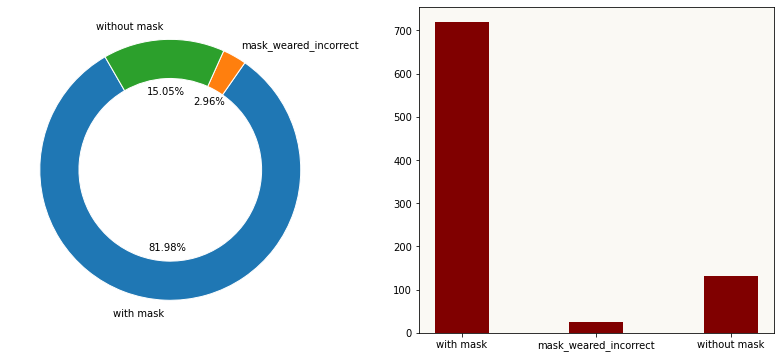

In [ ]:
with_mask_count     = 0
without_mask_count  = 0
non_proper_count    = 0

for image in dataset_val:
  for annots_number in range(len(image[1]['labels'])):
    label = int(image[1]['labels'][annots_number])
    if label   == 1:
      with_mask_count += 1
    elif label == 2:
      non_proper_count += 1
    elif label == 3:
      without_mask_count += 1



fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie([with_mask_count,non_proper_count,without_mask_count],wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=['with mask','mask_weared_incorrect','without mask'], radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(['with mask','mask_weared_incorrect','without mask'], [with_mask_count,non_proper_count,without_mask_count],
              color ='maroon',width = 0.4)

plt.show()

In [ ]:
# # Number of each class in the validation set

with_mask_count,without_mask_count,non_proper_count

(719, 132, 26)

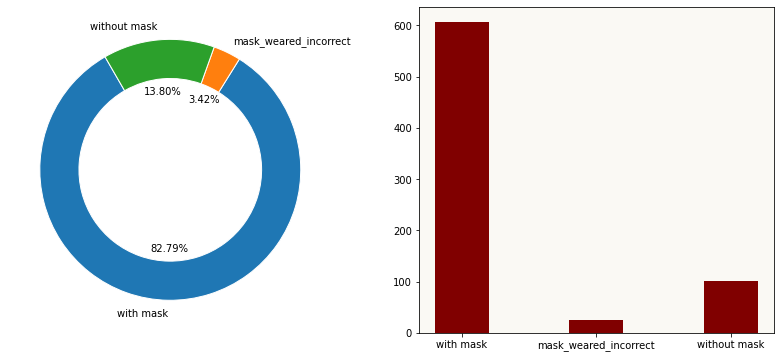

In [ ]:
with_mask_count     = 0
without_mask_count  = 0
non_proper_count    = 0

for image in dataset_test:
  for annots_number in range(len(image[1]['labels'])):
    label = int(image[1]['labels'][annots_number])
    if label   == 1:
      with_mask_count += 1
    elif label == 2:
      non_proper_count += 1
    elif label == 3:
      without_mask_count += 1



fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie([with_mask_count,non_proper_count,without_mask_count],wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=['with mask','mask_weared_incorrect','without mask'], radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(['with mask','mask_weared_incorrect','without mask'], [with_mask_count,non_proper_count,without_mask_count],
              color ='maroon',width = 0.4)

plt.show()

In [ ]:
# Number of each class in the test set

with_mask_count,without_mask_count,non_proper_count

(606, 101, 25)

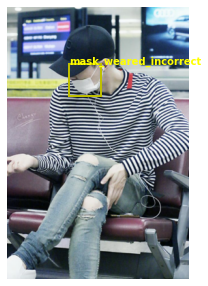

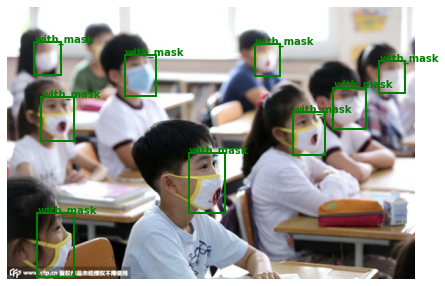

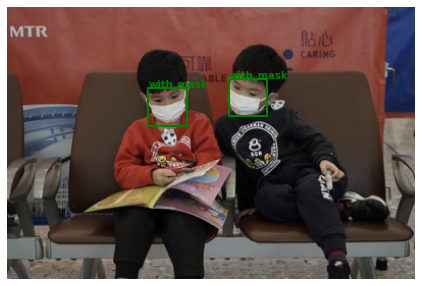

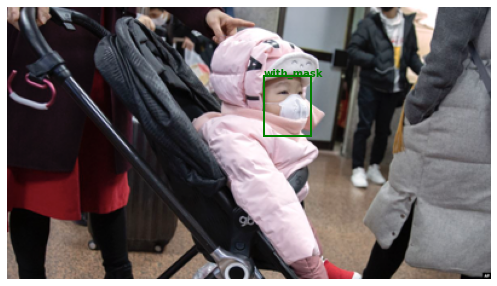

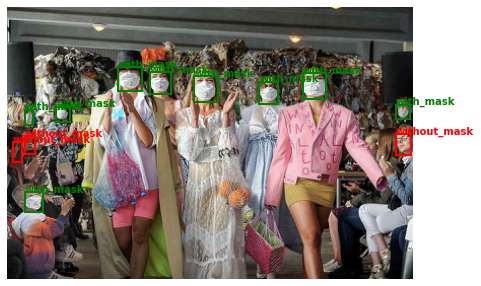

In [ ]:
# for better understanding of data, we would show some images in the dataset
# we would annotate the faces with the corresponding label and with its bounding box

import matplotlib.patches as mpatches

def mask_image_show(image_object):

  fig,ax=plt.subplots(1)
  ax.axis("off")
  fig.set_size_inches(10,5)

  img = image_object[0].permute(1,2,0)
  # plt.imshow(img)

  for annots_number in range(len(image_object[1]['labels'])):
    bbox  = image_object[1]['boxes'][annots_number]
    label = int(image_object[1]['labels'][annots_number])
    if label == 1:
      x,y,w,h=list(map(int,bbox))
      mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
      ax.add_patch(mpatch)
      rx, ry = mpatch.get_xy()
      ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
      

    if label == 2:
      x,y,w,h=list(map(int,bbox))
      mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
      ax.add_patch(mpatch)
      rx, ry = mpatch.get_xy()
      ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')

    if label == 3:
      x,y,w,h=list(map(int,bbox))
      mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
      ax.add_patch(mpatch)
      rx, ry = mpatch.get_xy()
      ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')

    plt.imshow(img)

c = 0
for image in dataset_train:
  mask_image_show(image)
  if c == 4:
    break
  c +=1

# Data Loading

In [ ]:
# In this section we are trying to extract each faces in the images and creat a
# separate datasets for them. We are cropping faces with their bounding boxes.
#  Also, we would resize all the cropped faces in a same size in order to input
# in the model

from torchvision import datasets,transforms

def dataset_creation(dataset):
    one_hot = torch.zeros(3) 
    image_tensor=[]
    label_tensor=[]
    for image_object in (dataset):
      for annots_number in range(len(image_object[1]['labels'])):
        bbox  = image_object[1]['boxes'][annots_number]
        label = int(image_object[1]['labels'][annots_number])-1
        # one_hot = torch.zeros(3)
        # one_hot[label-1] = 1  
        x,y,w,h=list(map(int,bbox))
        # image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
        image = image_object[0][:,y:h,x:w]
        image_tensor.append(my_transform(image))
        label_tensor.append(torch.tensor(label))
        # label_tensor.append(torch.tensor(one_hot))
    # print(image_tensor)
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor()])

train = dataset_creation(dataset_train)
val   = dataset_creation(dataset_val)
test  = dataset_creation(dataset_test)

In [ ]:
# since the data is highly imbalanced we have used this part to add some
# weights to each class to get a more accurate result

from torch.utils.data import WeightedRandomSampler

samples_weight = torch.tensor([1/82*2,1/3*2,1/13*2]).cuda()
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [ ]:
# We would use PyTorch dataloader to make them ready for our models

train_dataloader =DataLoader(dataset = train ,batch_size=32,num_workers=4)
val_dataloader   =DataLoader(dataset = test  ,batch_size=32,num_workers=4)
test_dataloader  =DataLoader(dataset = val   ,batch_size=32,num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

print(device)

cuda:0


# Metric Functions

In [ ]:
# With this function we would compute overall accuracy for an specific data set

def Overall_acc(network, test):

  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for images, labels in test:
          if torch.cuda.is_available():
              images , labels = images.cuda(), labels.cuda()
          # calculate outputs by running images through the network
          outputs = network(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # return f'Accuracy of the network on the test images: {100 * correct // total} %'
  return (100* correct // total)
  


In [ ]:
# With this function we would have accuracy for each class in our dataset

def Class_acc(network, test):
  accuracy_list = []
  classes = ['With Mask','Incorrect Mask','No Mask']
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in test:
          if torch.cuda.is_available():
              images , labels = images.cuda(), labels.cuda()
          outputs = network(images)
          
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      # print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
      accuracy_list.append(accuracy)

  return accuracy_list

# Simple ConvNet Model

In this part we would creat a ConvNet and try to train it from scratch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = F.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        return x


model1 = ConvNet()
if torch.cuda.is_available():
    model1.cuda()
    print('on CUDA')

on CUDA


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss(weight = samples_weight) #using weights that we have introduced before for tackling imbalancment
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 10

# these lists contains each epochs performance
convnet_train_losses = []
convnet_val_losses = []
convnet_train_overal_acc = []
convnet_val_overal_acc = []
convnet_train_class_acc = []
convnet_val_class_acc = []

#for printing and verbose
val_number = 5
print_number = 5

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]

        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()

        # print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        # print(outputs.shape)


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % val_number == val_number -1:          
          
          val_running_loss = 0.0
          for val_inputs, val_labels in val_dataloader:

            if torch.cuda.is_available():
              val_inputs , val_labels = val_inputs.cuda(), val_labels.cuda()

            optimizer.zero_grad()
            val_outputs = model1(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()

          convnet_val_losses.append(val_running_loss/len(val_dataloader))

          convnet_train_losses.append(running_loss/20)
          
          # computing epochs metrics
          c_t_o_a = Overall_acc(model1,train_dataloader)
          c_v_o_a = Overall_acc(model1,val_dataloader)

          c_t_c_a = Class_acc(model1,train_dataloader)
          c_v_c_a = Class_acc(model1,val_dataloader)

          convnet_train_overal_acc.append(c_t_o_a)
          convnet_val_overal_acc.append(c_v_o_a)
          convnet_train_class_acc.append(c_t_c_a)
          convnet_val_class_acc.append(c_v_c_a)

        # if i % print_number == print_number -1:
          print(f"Epoch {epoch}, batch: {i+1}, training loss: {running_loss/20},  validation loss: {val_running_loss/len(val_dataloader)}, training accuracy: {c_t_o_a}, validation accuracy: {c_v_o_a}")
          running_loss = 0.0


Epoch 0, batch: 5, training loss: 0.2797569990158081,  validation loss: 1.0947700324265852, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 10, training loss: 0.279128235578537,  validation loss: 1.0944636023562888, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 15, training loss: 0.2752246677875519,  validation loss: 1.0948126730711565, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 20, training loss: 0.2738679230213165,  validation loss: 1.0935816920321921, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 25, training loss: 0.275404679775238,  validation loss: 1.0924522202947866, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 30, training loss: 0.27297130823135374,  validation loss: 1.0913211262744407, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 35, training loss: 0.2730085074901581,  validation loss: 1.0901963555294534, training accuracy: 77, validation accuracy: 82
Epoch 0, batch: 40, tr

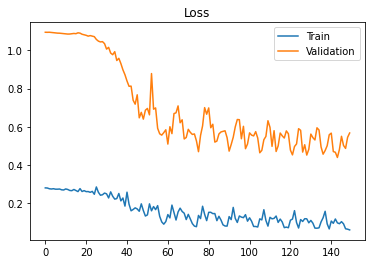

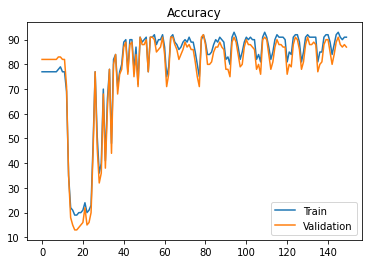

In [ ]:
plt.figure()

plt.title('Loss')
plt.plot(convnet_train_losses)
plt.plot(convnet_val_losses)
plt.legend(['Train','Validation'])

plt.figure()
plt.title('Accuracy')
plt.plot(convnet_train_overal_acc)
plt.plot(convnet_val_overal_acc)
plt.legend(['Train','Validation'])

plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model1(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 90 %


In [ ]:
classes = ['With Mask','Incorrect Mask','No Mask']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

confusion_matrix = np.zeros((3,3))
# again no gradients needed
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        outputs = model1(images)
        
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            confusion_matrix[prediction,label] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: With Mask is 90.8 %
Accuracy for class: Incorrect Mask is 65.4 %
Accuracy for class: No Mask is 97.0 %


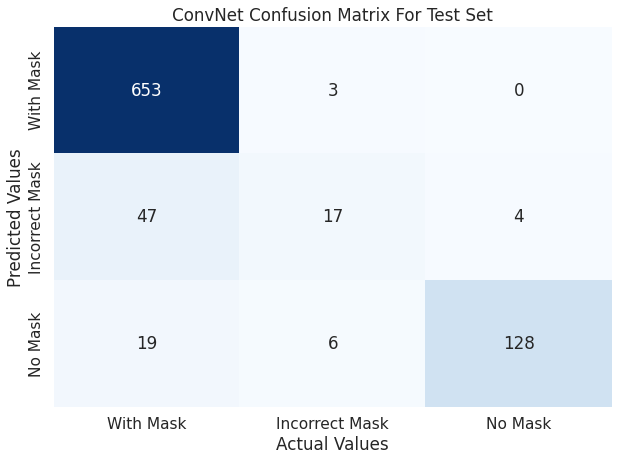

In [ ]:
df_cm = pd.DataFrame(confusion_matrix,dtype = 'int', index = classes,
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g',cbar=False)
plt.title('ConvNet Confusion Matrix For Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Using VGG Model with pretrained weights

in this step we would use VGG16 with pretrained weights that we would download it

In [ ]:
from torchvision import models
model2 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Making few layers trainable 

counter = 0

for param in model2.parameters():
    if counter < 31:
      param.requires_grad=True
    else:
      param.requires_grad=False
    counter += 1


In [ ]:
# in this part we would modify the model so it can predict for 3 classes (as in our case,
# images are classified into three categories)

import torch.nn as nn
import torch.optim as optim
num_classes = 3


model2.classifier[6].out_features = 3 
model2.classifier[6].weight = torch.nn.Parameter(torch.randn(model2.classifier[6].out_features, model2.classifier[6].in_features),requires_grad=True)
model2.classifier[6].bias = torch.nn.Parameter(torch.randn(model2.classifier[6].out_features), requires_grad=True)
model2.eval()

model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# creating the loss function and optimizer. again we have used weights to tackle imbalancement
criterion = nn.CrossEntropyLoss(weight = samples_weight)
optimizer=optim.SGD(model2.parameters(),lr=0.000001,momentum=0.9)

In [ ]:
n_epochs = 10
val_number = 5
print_number = 5

if torch.cuda.is_available():
    model2.cuda()

# epochs metrics
vgg_train_losses = []
vgg_val_losses = []
vgg_train_overal_acc = []
vgg_val_overal_acc = []
vgg_train_class_acc = []
vgg_val_class_acc = []

for epoch in range(n_epochs): 
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % val_number == val_number -1:
          
          val_running_loss = 0.0
          for val_inputs, val_labels in val_dataloader:

            if torch.cuda.is_available():
              val_inputs , val_labels = val_inputs.cuda(), val_labels.cuda()

            optimizer.zero_grad()
            val_outputs = model2(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()

          vgg_val_losses.append(val_running_loss/len(val_dataloader))

          vgg_train_losses.append(running_loss/20)

          #computing metrics of the epochs
          v_t_o_a = Overall_acc(model2,train_dataloader)
          v_v_o_a = Overall_acc(model2,val_dataloader)

          v_t_c_a = Class_acc(model2,train_dataloader)
          v_v_c_a = Class_acc(model2,val_dataloader)

          vgg_train_overal_acc.append(v_t_o_a)
          vgg_val_overal_acc.append(v_v_o_a)
          vgg_train_class_acc.append(v_t_c_a)
          vgg_val_class_acc.append(v_v_c_a)


          print(f"Epoch {epoch}, batch: {i+1}, training loss: {running_loss/20},  validation loss: {val_running_loss/len(val_dataloader)}, training accuracy: {v_t_o_a}, validation accuracy: {v_v_o_a}")
          running_loss = 0.0

Epoch 0, batch: 5, training loss: 6.19995436668396,  validation loss: 24.183820786683455, training accuracy: 40, validation accuracy: 40
Epoch 0, batch: 10, training loss: 3.3401209115982056,  validation loss: 20.377274844957434, training accuracy: 48, validation accuracy: 50
Epoch 0, batch: 15, training loss: 4.54835392832756,  validation loss: 15.846926906834478, training accuracy: 55, validation accuracy: 56
Epoch 0, batch: 20, training loss: 1.8859834313392638,  validation loss: 12.591321489085322, training accuracy: 56, validation accuracy: 57
Epoch 0, batch: 25, training loss: 2.702123448252678,  validation loss: 10.464210188907126, training accuracy: 40, validation accuracy: 41
Epoch 0, batch: 30, training loss: 2.2648887515068052,  validation loss: 10.443778349005658, training accuracy: 31, validation accuracy: 28
Epoch 0, batch: 35, training loss: 1.8255611181259155,  validation loss: 9.433711326640585, training accuracy: 37, validation accuracy: 33
Epoch 0, batch: 40, trainin

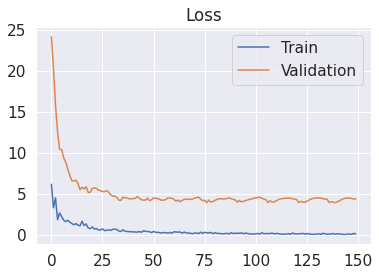

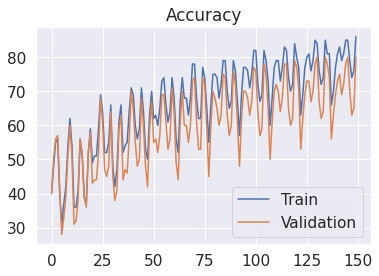

In [ ]:
plt.figure()

plt.title('Loss')
plt.plot(vgg_train_losses)
plt.plot(vgg_val_losses)
plt.legend(['Train','Validation'])

plt.figure()
plt.title('Accuracy')
plt.plot(vgg_train_overal_acc)
plt.plot(vgg_val_overal_acc)
plt.legend(['Train','Validation'])

plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 82 %


In [ ]:
classes = ['With Mask','Incorrect Mask','No Mask']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

confusion_matrix = np.zeros((3,3))
# again no gradients needed
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        outputs = model2(images)
        
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            confusion_matrix[prediction,label] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: With Mask is 89.8 %
Accuracy for class: Incorrect Mask is 19.2 %
Accuracy for class: No Mask is 56.8 %


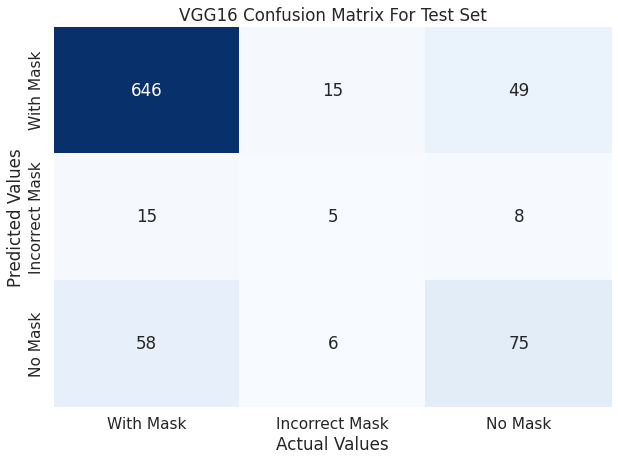

In [ ]:
df_cm = pd.DataFrame(confusion_matrix,dtype = 'int', index = classes,
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g',cbar=False)
plt.title('VGG16 Confusion Matrix For Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Using ResNet34 with pretrained weights

Finally we would use ResNet architecture with pretrained weights.
We should note that theses weights are from ImageNet with 1000 classes
and we should modify the model later when we want tto use it for our case
(just like how we did for VGG)

In [ ]:
from torchvision import models
model3=models.resnet34(pretrained=True)

In [ ]:
# first we would make all layers un-trainable
for param in model3.parameters():
    param.requires_grad=False

In [ ]:
# modify the model based on our case

import torch.nn as nn
import torch.optim as optim
num_classes = 3


model3.fc.out_features= num_classes
model3.fc.weight = torch.nn.Parameter(torch.randn(model3.fc.out_features, model3.fc.in_features),
 requires_grad=True)
model3.fc.bias = torch.nn.Parameter(torch.randn(model3.fc.out_features), requires_grad=True) # same with the bias
model3.eval() # this is necessary for batch normalization layers
print('reinitialize model with output features as 3 :', model3.fc.out_features)

model3

reinitialize model with output features as 3 : 3


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# we can have all of feature for out model

features_resnet34 = []
for key,value in model3._modules.items():
    features_resnet34.append(value)


In [ ]:
# initializing the model

conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param )

samples_weight = torch.tensor([1/82*2,1/3*2,1/13*2]).cuda()
criterion = nn.CrossEntropyLoss(weight = samples_weight)
optimizer=optim.SGD(model3.parameters(),lr=0.001,momentum=0.9)

 Number of Parameters for conv2D is : 73728


In [ ]:
#make the last layer trainable
param.requires_grad=True
ct = 0
for child in model3.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
val_number = 10
print_number = 5
n_epochs = 10

if torch.cuda.is_available():
    model3.cuda()

#epochs metrics
resnet34_train_losses = []
resnet34_val_losses = []
resnet34_train_overal_acc = []
resnet34_val_overal_acc = []
resnet34_train_class_acc = []
resnet34_val_class_acc = []

for epoch in range(n_epochs): 
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % val_number == val_number -1:

          val_running_loss = 0.0
          for val_inputs, val_labels in val_dataloader:

            if torch.cuda.is_available():
              val_inputs , val_labels = val_inputs.cuda(), val_labels.cuda()

            optimizer.zero_grad()
            val_outputs = model3(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()

          resnet34_val_losses.append(val_running_loss/len(val_dataloader))

          resnet34_train_losses.append(running_loss/20)
          
          #calculating current epochs metrics
          r_t_o_a = Overall_acc(model3,train_dataloader)
          r_v_o_a = Overall_acc(model3,val_dataloader)

          r_t_c_a = Class_acc(model3,train_dataloader)
          r_v_c_a = Class_acc(model3,val_dataloader)

          resnet34_train_overal_acc.append(r_t_o_a)
          resnet34_val_overal_acc.append(r_v_o_a)
          resnet34_train_class_acc.append(r_t_c_a)
          resnet34_val_class_acc.append(r_v_c_a)          

          print(f"Epoch {epoch}, batch: {i+1}, training loss: {running_loss/20},  validation loss: {val_running_loss/len(val_dataloader)}, training accuracy: {r_t_o_a}, validation accuracy: {r_v_o_a}")
          running_loss = 0.0  

Epoch 0, batch: 10, training loss: 7.661982440948487,  validation loss: 15.849412607110064, training accuracy: 30, validation accuracy: 24
Epoch 0, batch: 20, training loss: 5.638564682006836,  validation loss: 9.433253770289214, training accuracy: 63, validation accuracy: 64
Epoch 0, batch: 30, training loss: 4.188909941911698,  validation loss: 7.823383517887281, training accuracy: 46, validation accuracy: 48
Epoch 0, batch: 40, training loss: 3.690989100933075,  validation loss: 8.780516914699389, training accuracy: 31, validation accuracy: 26
Epoch 0, batch: 50, training loss: 4.181567907333374,  validation loss: 7.389193379360696, training accuracy: 39, validation accuracy: 36
Epoch 0, batch: 60, training loss: 3.153567707538605,  validation loss: 6.846517049747964, training accuracy: 42, validation accuracy: 43
Epoch 0, batch: 70, training loss: 1.734306675195694,  validation loss: 6.946728022202201, training accuracy: 40, validation accuracy: 37
Epoch 1, batch: 10, training loss

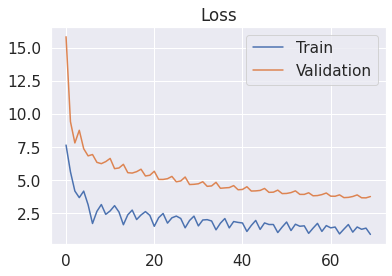

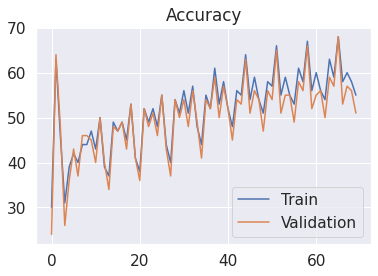

In [ ]:
plt.figure()

plt.title('Loss')
plt.plot(resnet34_train_losses)
plt.plot(resnet34_val_losses)
plt.legend(['Train','Validation'])

plt.figure()
plt.title('Accuracy')
plt.plot(resnet34_train_overal_acc)
plt.plot(resnet34_val_overal_acc)
plt.legend(['Train','Validation'])

plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model3(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 67 %


In [ ]:
classes = ['With Mask','Incorrect Mask','No Mask']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

confusion_matrix = np.zeros((3,3))

# again no gradients needed
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images , labels = images.cuda(), labels.cuda()
        outputs = model3(images)
        
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            confusion_matrix[prediction,label] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: With Mask is 70.0 %
Accuracy for class: Incorrect Mask is 50.0 %
Accuracy for class: No Mask is 56.1 %


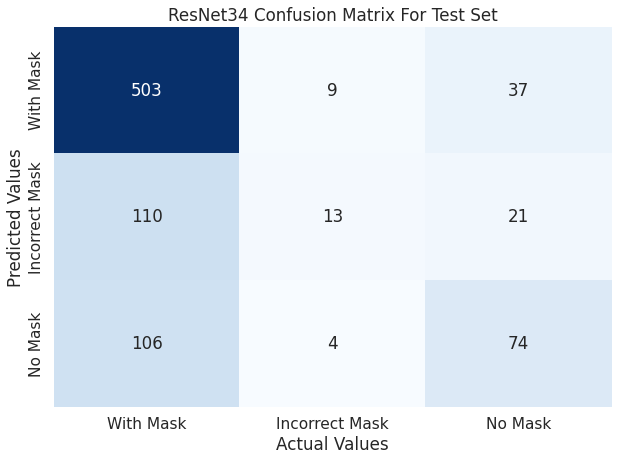

In [ ]:
df_cm = pd.DataFrame(confusion_matrix,dtype = 'int', index = classes,
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g',cbar=False)
plt.title('ResNet34 Confusion Matrix For Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()